In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

import sys
sys.path.append("/home/tester/Desktop/TF/gower/gower")
import gower_dist as gd

#import gower


2022-06-29 11:43:57.055017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 11:43:57.055049: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_Network_dataset/Train_Test_Network.csv")
df.pop('type')
df.pop('ts')
df.head()

#reduced_df = df[["src_port", "proto", "service", "dst_port", "duration", "label"]]

    #'proto', 'service', 'conn_state', 'dns_query', 'ssl_version',
    # 'ssl_cipher', 'ssl_subject', 'ssl_issuer', 'http_method', 'http_uri',
    # 'http_version', 'http_orig_mime_types', 'http_resp_mime_types',
    # 'weird_name', 'weird_addl']]
#df = reduced_df

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label
0,3.122.49.24,1883,192.168.1.152,52976,tcp,-,80549.530260,1762852,41933215,OTH,...,0,0,0,-,-,-,bad_TCP_checksum,-,F,0
1,192.168.1.79,47260,192.168.1.255,15600,udp,-,0.000000,0,0,S0,...,0,0,0,-,-,-,-,-,-,0
2,192.168.1.152,1880,192.168.1.152,51782,tcp,-,0.000000,0,0,OTH,...,0,0,0,-,-,-,bad_TCP_checksum,-,F,0
3,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,OTH,...,0,0,0,-,-,-,-,-,-,0
4,192.168.1.152,46608,192.168.1.190,53,udp,dns,0.000549,0,298,SHR,...,0,0,0,-,-,-,bad_UDP_checksum,-,F,0


In [3]:

# transformer = make_column_transformer(
#     (OneHotEncoder(), ['proto', 'service']),
#     # 'ssl_cipher', 'ssl_subject', 'ssl_issuer', 'http_method', 'http_uri',
#     # 'http_version', 'http_orig_mime_types', 'http_resp_mime_types',
#     # 'weird_name', 'weird_addl']),
#     remainder='passthrough')
# 
# transformed = transformer.fit_transform(df)
# transformed_df = pd.DataFrame(
#     transformed, 
#     columns=transformer.get_feature_names_out()
# )

## Perform outlier detection

## Compute gower dist manually

In [3]:
cat_indexs = [0, 1, 2, 3, 4, 5, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41]
num_indexs = [6, 7, 8, 10, 11, 12, 13, 14, 33, 34]
#bool_indexs = []


In [5]:
def compute_ranges(data, num_indexs):
    ranges = []
    for l in num_indexs:
        ranges.append(np.max(data.iloc[:,l].values) - np.min(data.iloc[:,l].values))
    return ranges


In [6]:
ranges = compute_ranges(df, num_indexs)
print(ranges)

[93516.92917, 3890855126, 3913853482, 1854527046, 252181, 47367248, 313943, 86395523, 2338, 13424384]


In [7]:
def gower_distance_i_j(instance_i, instance_j, cat_indexs, num_indexs, ranges):
    #Qualitat
    cat_len = len(cat_indexs)
    alpha = 0.
    for l in cat_indexs:
        if(instance_i[l] == instance_j[l]):
            alpha = alpha + 1.
    #Numeric
    cnt = 0
    num_len = len(num_indexs)
    beta = 0.
    #eps = 0.000001
    for l in num_indexs:
        #if ranges[cnt] != 0:
        beta = beta + (1-np.abs(instance_i[l]-instance_j[l])/(ranges[cnt]))
        #else:
        #    num_len = num_len - 1
        cnt = cnt + 1
    s_i_j = (alpha + beta)/(cat_len+num_len)
    return 1.-s_i_j

In [8]:
def compute_gower_mat(data, cat_indexs, num_indexs, ranges):
    mat = []
    #feature_num = len(cat_indexs)+len(num_indexs)
    for i in range(0,len(data)):
        row = []
        for j in range(0,len(data)):
            row.append(gower_distance_i_j(df.loc[i].values, df.loc[j].values, cat_indexs, num_indexs, ranges))
        mat.append(row)
    return mat

#for index, row in df.iterrows():
#    print(row.values)

## Single func when new data arrives

In [4]:
# Which cols are categorical
cat_index_bool = [False] * 42
for e in cat_indexs:
    cat_index_bool[e] = True

In [10]:
TRAIN_SIZE = 10000
TEST_SIZE = 20000

In [11]:
data = df.sample(TRAIN_SIZE+TEST_SIZE, random_state=21)

train_data = data.head(TRAIN_SIZE)
train_labels = train_data.pop('label')
test_data = data.tail(TEST_SIZE)
test_labels = test_data.pop('label')

labels = data.pop('label')


In [12]:
train_gower_mat = gd.gower_matrix_limit_cols(train_data,TRAIN_SIZE,cat_features=cat_index_bool)

(10000, 10000)


Compute gower dist per instance in test

In [13]:
cat_index_bool = np.array(cat_index_bool)

data = np.asarray(data)

cat_data = data[:,cat_index_bool]
num_data = data[:,np.logical_not(cat_index_bool)]

cat_cols = cat_data.shape[1]
num_cols = num_data.shape[1]

weight = np.ones(42)
weight_cat=weight[cat_index_bool]
weight_num=weight[np.logical_not(cat_index_bool)]
weight_sum = weight.sum()

num_ranges = np.zeros(num_cols)
num_max = np.zeros(num_cols)

for col in range(num_cols):
    col_array = num_data[:, col].astype(np.float32) 
    max = np.nanmax(col_array)
    min = np.nanmin(col_array)
 
    if np.isnan(max):
        max = 0.0
    if np.isnan(min):
        min = 0.0
    num_max[col] = max
    num_ranges[col] = (1 - min / max) if (max != 0) else 0.0

num_data = np.divide(num_data ,num_max,out=np.zeros_like(num_data), where=num_max!=0)
#print(num_data.shape)

In [14]:
test_gower_mat = []
for i in range(TRAIN_SIZE, TRAIN_SIZE+TEST_SIZE):
    dist = gd.gower_get(cat_data[i,:], num_data[i,:], cat_data[0:TRAIN_SIZE,:], num_data[0:TRAIN_SIZE,:], weight_cat, weight_num, weight_sum, cat_index_bool, num_ranges, num_max)
    test_gower_mat.append(np.float32(dist))
test_gower_mat = np.array(test_gower_mat)

In [ ]:
#print(gower_distance_i_j(sample1.loc[0].values, sample1.loc[0].values, cat_indexs, num_indexs, ranges))

In [ ]:
#dis = gower_distance_i_j(df.loc[0].values, df.loc[0].values, cat_indexs, num_indexs, ranges)
#print(dis)

In [ ]:
# Percentage malware
perc = len(df.loc[df['label']==1])/len(df)
print(perc)

In [ ]:
# Balance dataset
num_anom = len(df.loc[df['label']==1.])
df_anom = df.loc[df['label']==1.]
df_normal = df.loc[df['label']==0.]
df_normal = df_normal.sample(num_anom, replace=False)
df_concated = pd.concat([df_normal, df_anom])
balanced_data = df_concated

In [ ]:
data = balanced_data.sample(4500, random_state=21)

#train_data = data.sample(3000, random_state=21)
#test_data = data.sample(1500, random_state=18)

#train_data = data[0:3000]
#test_data = data[3000:6000]

labels = data.pop('label')
train_labels = np.array(labels[0:1000])
test_labels = np.array(labels[1000:4500])

In [ ]:
gower_mat = gd.gower_matrix(data)
train_gower_mat = gower_mat[0:1000,0:1000]
test_gower_mat = gower_mat[1000:4500,0:3000]

In [ ]:
print(train_gower_mat.shape)

In [ ]:
print(test_gower_mat.shape)

In [ ]:
# Unbalanced dataset

# unbalanced_data = df.copy()
# data = unbalanced_data.sample(6000, random_state=21)
# train_data = data[0:3000]
# test_data = data[3000:6000]
# train_data.pop('type')
# test_data.pop('type')
# train_labels = train_data.pop('label')
# test_labels = test_data.pop('label')
# 
# train_gower_mat = gower.gower_dist.gower_matrix(train_data)
# test_gower_mat = gower.gower_dist.gower_matrix(test_data)

In [ ]:
# data_scaled = data.copy()
# min_max_scaler = MinMaxScaler()
# #data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]] = min_max_scaler.fit_transform(data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]])
# data_scaled[data_scaled.columns] = min_max_scaler.fit_transform(data_scaled[data_scaled.columns])
# print(data_scaled.shape)

In [ ]:
# train_data, test_data, train_labels, test_labels = train_test_split(train_gower_mat, unbalanced_labels, test_size=0.33, random_state=21)

In [ ]:
# Separe normal and anomaly classes

#train_labels = train_labels.astype(bool)
#test_labels = test_labels.astype(bool)

# normal_train_data = train_data[~train_labels]
# normal_test_data = test_data[~test_labels]
# 
# anomalous_train_data = train_data[train_labels]
# anomalous_test_data = test_data[test_labels]

In [ ]:
# print(normal_train_data[0])

In [ ]:
# plt.plot(normal_train_data[0])
# #plt.plot(normal_train_data[1])
# #plt.plot(normal_train_data[2])
# plt.title("Normal Data")
# plt.show()

In [ ]:
# plt.plot(anomalous_train_data[0])
# #plt.plot(anomalous_train_data[1])
# #plt.plot(anomalous_train_data[2])
# plt.title("Anomaly Data")
# plt.show()

In [ ]:
# train_data = np.array(train_data)
# normal_train_data = np.array(normal_train_data)
# normal_test_data = np.array(normal_test_data)
# anomalous_train_data = np.array(anomalous_train_data)
# anomalous_test_data = np.array(anomalous_test_data)

In [ ]:
# class AutoEncoder(Model):
#   def __init__(self):
#     super(AutoEncoder, self).__init__()
#     self.encoder = tf.keras.Sequential([
#                   tf.keras.layers.Dense(64, activation="relu"),
#                   tf.keras.layers.Dense(32, activation="relu"),
#                   tf.keras.layers.Dense(16, activation="relu"),
#                   tf.keras.layers.Dense(8, activation="relu")
#               ])
#     self.decoder = tf.keras.Sequential([
#                   tf.keras.layers.Dense(16, activation="relu"),
#                   tf.keras.layers.Dense(32, activation="relu"),
#                   tf.keras.layers.Dense(64, activation="relu"),
#                   tf.keras.layers.Dense(16, activation="sigmoid")
#               ])
#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

In [15]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(10000,)),
      tf.keras.layers.Dense(1024, activation="relu"),
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      #tf.keras.layers.Dense(256, activation="relu"),
      #tf.keras.layers.Dense(256, activation="relu"),
      #tf.keras.layers.Dense(256, activation="relu"),
      #tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(2),
      #tf.keras.layers.Dense(2, activation="relu"),
      #tf.keras.layers.Dense(32, activation="relu"),
      #tf.keras.layers.Dense(4, activation="relu"),
      #tf.keras.layers.Dense(1, activation="sigmoid"),
      tf.keras.layers.Softmax()
  ])

In [16]:
train_data = train_gower_mat

In [17]:
model = create_keras_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
loss = [tf.keras.losses.SparseCategoricalCrossentropy()]
model.compile(optimizer=opt, loss=loss, metrics = metrics)

2022-06-17 06:51:57.320165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-17 06:51:57.320225: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-17 06:51:57.320248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2022-06-17 06:51:57.320565: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
history = model.fit(train_data, train_labels, epochs=300, batch_size=32,
                    validation_data=(train_data, train_labels),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/300


2022-06-17 06:52:01.354566: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.


312/313 [============================>.] - ETA: 0s - loss: 0.4278 - sparse_categorical_accuracy: 0.8180

2022-06-17 06:52:13.333594: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.


313/313 [==============================] - 14s 44ms/step - loss: 0.4277 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.3196 - val_sparse_categorical_accuracy: 0.8687
Epoch 2/300
313/313 [==============================] - 14s 44ms/step - loss: 0.2344 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.1882 - val_sparse_categorical_accuracy: 0.9366
Epoch 3/300
313/313 [==============================] - 13s 43ms/step - loss: 0.1736 - sparse_categorical_accuracy: 0.9307 - val_loss: 0.1395 - val_sparse_categorical_accuracy: 0.9487
Epoch 4/300
313/313 [==============================] - 14s 44ms/step - loss: 0.1284 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.1078 - val_sparse_categorical_accuracy: 0.9628
Epoch 5/300
313/313 [==============================] - 14s 45ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.1032 - val_sparse_categorical_accuracy: 0.9695
Epoch 6/300
313/313 [==============================] - 13s 40ms/step - loss: 0.0874 - sparse_cate

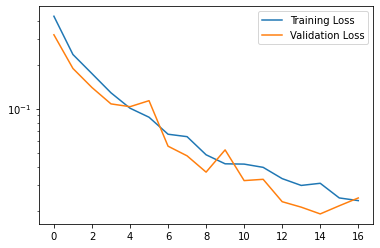

In [19]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.yscale('log')
plt.legend()

In [20]:
results = model.evaluate(test_gower_mat, test_labels)
print("test loss, test acc:", results)

  9/625 [..............................] - ETA: 4s - loss: 0.0132 - sparse_categorical_accuracy: 0.9965  

2022-06-17 06:56:24.072055: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 800000000 exceeds 10% of free system memory.


625/625 [==============================] - 4s 6ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9949
test loss, test acc: [0.0264743585139513, 0.9948999881744385]


In [21]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions))) #sensitivity
  print("F1 = {}".format(f1_score(labels, predictions)))
  print("ROC_AUC = {}".format(roc_auc_score(labels, predictions)))

In [ ]:
len(test_gower_mat[0])

In [22]:
# Results dont make sense give more weight to anomaly class in the learning process
preds = model.predict(test_gower_mat)
#y_classes = preds.argmax(axis=-1)
#print_stats(preds, test_labels)

2022-06-17 06:56:29.585846: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 800000000 exceeds 10% of free system memory.


In [23]:
print_stats(np.round(preds[:,1], decimals=0), test_labels.astype(int))

Accuracy = 0.9949
Precision = 0.9988409156766155
Recall = 0.9865483686319405
F1 = 0.9926565874730023
ROC_AUC = 0.9929667757700127
